Note: Much code taken from Neuromatch NeuroAI 2024 Microlearning.

## Dependencies

In [1]:
# dependencies
from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io
from scipy.ndimage import uniform_filter1d

## Plotting and metrics imports
from metrics import get_plotting_color, plot_examples, plot_class_distribution, plot_results, plot_scores_per_class, plot_weights

## Other functions imports
from helpers import sigmoid, ReLU, add_bias, create_batches, calculate_accuracy, calculate_cosine_similarity, calculate_grad_snr

## MLP imports
from MLP import MLP, NodePerturbMLP, KolenPollackMLP

## Data

In [2]:
# Download MNIST function
def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    
    rng_data = np.random.default_rng(seed=42)
    train_num = 50000
    shuffled_train_idx = rng_data.permutation(train_num)

    full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform)
    full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform)
    
    full_train_images = full_train_set.data.numpy().astype(float) / 255
    train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, 784)).T.copy()
    valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, 784)).T.copy()
    test_images = (full_test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

    full_train_labels = torch.nn.functional.one_hot(full_train_set.targets, num_classes=10).numpy()
    train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
    valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
    test_labels = torch.nn.functional.one_hot(full_test_set.targets, num_classes=10).numpy().T

    train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set, [train_prop * keep_prop, valid_prop * keep_prop, discard_prop])
    test_set, _ = torch.utils.data.random_split(
      full_test_set, [keep_prop, discard_prop])

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels

In [3]:
train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels = download_mnist()

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


## Hyperparams

In [4]:
#HYPERPARAMETERS
NUM_INPUTS = 784
NUM_OUTPUTS = 10
numhidden = 500
batchsize = 128
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 25
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345

In [5]:
# set random seed
rng = np.random.default_rng(seed=seed)

indices = np.random.choice(test_images.shape[1], size=1000, replace=False)

## Backprop

In [45]:
# Normal learning
netbackprop = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_normal, accuracy_bp_normal, test_loss_bp_normal, snr_bp_normal, cosine_similarity_bp_normal) = \
    netbackprop.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

Training starting...


KeyboardInterrupt: 

In [9]:
# Online learning
from MLP import MLP, NodePerturbMLP, KolenPollackMLP

net_bp_online = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_online, accuracy_bp_online, test_loss_bp_online, snr_bp_online, cosine_similarity_bp_online) = \
    net_bp_online.train_online(rng, train_images, train_labels, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=0.01, max_it=50000, conv_loss = 1e-1, algorithm='backprop', noise=noise, \
                      report=report, report_rate=batchsize)

Training starting...
At iteration 1, the accuracy is 11.600000000000001
At iteration 129, the accuracy is 11.3
At iteration 257, the accuracy is 16.0
At iteration 385, the accuracy is 9.6
At iteration 513, the accuracy is 24.7
At iteration 641, the accuracy is 14.099999999999998
At iteration 769, the accuracy is 20.3
At iteration 897, the accuracy is 24.099999999999998
At iteration 1025, the accuracy is 24.0
At iteration 1153, the accuracy is 10.2
At iteration 1281, the accuracy is 24.3
At iteration 1409, the accuracy is 33.900000000000006
At iteration 1537, the accuracy is 23.400000000000002
At iteration 1665, the accuracy is 33.6
At iteration 1793, the accuracy is 32.5
At iteration 1921, the accuracy is 33.5
At iteration 2049, the accuracy is 15.6
At iteration 2177, the accuracy is 45.5
At iteration 2305, the accuracy is 32.300000000000004
At iteration 2433, the accuracy is 47.0
At iteration 2561, the accuracy is 43.7
At iteration 2689, the accuracy is 52.1
At iteration 2817, the acc

KeyboardInterrupt: 

In [7]:
# Noisy Input
# create a network and train it using backprop
netbackprop_noisy = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_noisy, accuracy_bp_noisy, test_loss_bp_noisy, snr_bp_noisy, cosine_similarity_bp_noisy) = \
    netbackprop_noisy.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      noise_type='gauss',report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current training loss:  2.18  epochs of training. Current testing loss:  2.16
...completed  2.0  epochs of training. Current training loss:  2.02  epochs of training. Current testing loss:  1.98
...completed  3.0  epochs of training. Current training loss:  1.93  epochs of training. Current testing loss:  1.87
...completed  4.0  epochs of training. Current training loss:  1.88  epochs of training. Current testing loss:  1.81
...completed  5.0  epochs of training. Current training loss:  1.84  epochs of training. Current testing loss:  1.77
...completed  6.0  epochs of training. Current training loss:  1.81  epochs of training. Current testing loss:  1.74
...completed  7.0  epochs of training. Current training loss:  1.79  epochs of training. Current testing loss:  1.72
...completed  8.0  epochs of training. Current training loss:  1.78  epochs of training. Current testing loss:  1.71
...completed  9.0  epochs of training. Curr

In [8]:
# Non-Stationary Data
net_bp_nonstat = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_nonstat, accuracy_bp_nonstat, test_loss_bp_nonstat, snr_bp_nonstat, cosine_similarity_bp_nonstat) = \
    net_bp_nonstat.train_nonstat_data(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=1)

Training starting...
...completed  1  epochs of training. Current loss:  1.74
...completed  2  epochs of training. Current loss:  1.67
...completed  3  epochs of training. Current loss:  1.64
...completed  4  epochs of training. Current loss:  1.62
...completed  5  epochs of training. Current loss:  1.61
...completed  6  epochs of training. Current loss:  1.6
...completed  7  epochs of training. Current loss:  1.6
...completed  8  epochs of training. Current loss:  1.59
...completed  9  epochs of training. Current loss:  1.59
...completed  10  epochs of training. Current loss:  1.58
...completed  11  epochs of training. Current loss:  1.58
...completed  12  epochs of training. Current loss:  1.57
...completed  13  epochs of training. Current loss:  1.57
...completed  14  epochs of training. Current loss:  2.03
...completed  15  epochs of training. Current loss:  1.92
...completed  16  epochs of training. Current loss:  1.84
...completed  17  epochs of training. Current loss:  1.8
...co

## FFA

In [ ]:
# Normal Learning
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
netffa_online = net_ff_model.net_FF_model(rng)
(losses_ffa_online_ce, test_loss_ffa_online_ce, 
 losses_ffa_online_mse, test_loss_ffa_online_mse,
 accuracy_ffa_online) = netffa_online.train_online(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    max_it=150000, conv_loss=0.50, 
    report_rate=batchsize, lr=0.01,
    model='ff_com', return_loss='cross_entropy'
)

In [ ]:
print(len(losses_ffa_online_ce), 
      len(test_loss_ffa_online_ce),
      len(losses_ffa_online_mse),
      len(test_loss_ffa_online_mse),
      len(accuracy_ffa_online)
      )
np.save('results/netffa/losses_ffa_online_ce.npy', np.asarray(losses_ffa_online_ce))
np.save('results/netffa/test_loss_ffa_online_ce.npy', np.asarray(test_loss_ffa_online_ce))
np.save('results/netffa/losses_ffa_online_mse.npy', np.asarray(losses_ffa_online_mse))
np.save('results/netffa/test_loss_ffa_online_mse.npy', np.asarray(test_loss_ffa_online_mse))
np.save('results/netffa/accuracy_ffa_online.npy', np.asarray(accuracy_ffa_online))

In [ ]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ffa_nonstat = net_ff_model.net_FF_model(rng)
(losses_ffa_nonstat_ce, test_loss_ffa_nonstat_ce, 
 losses_ffa_nonstat_mse, test_loss_ffa_nonstat_mse,
 accuracy_ffa_nonstat) = net_ffa_nonstat.train_nonstationary(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)

In [ ]:
print(len(losses_ffa_nonstat_ce), 
      len(test_loss_ffa_nonstat_ce),
      len(losses_ffa_nonstat_mse),
      len(test_loss_ffa_nonstat_mse),
      len(accuracy_ffa_nonstat)
      )
np.save('results/netffa/losses_ffa_nonstat_ce.npy', np.asarray(losses_ffa_nonstat_ce))
np.save('results/netffa/test_loss_ffa_nonstat_ce.npy', np.asarray(test_loss_ffa_nonstat_ce))
np.save('results/netffa/losses_ffa_nonstat_mse.npy', np.asarray(losses_ffa_nonstat_mse))
np.save('results/netffa/test_loss_ffa_nonstat_mse.npy', np.asarray(test_loss_ffa_nonstat_mse))
np.save('results/netffa/accuracy_ffa_nonstat.npy', np.asarray(accuracy_ffa_nonstat))

In [ ]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ffa_noisy = net_ff_model.net_FF_model(rng)
(losses_ffa_noisy_ce, test_loss_ffa_noisy_ce, 
 losses_ffa_noisy_mse, test_loss_ffa_noisy_mse,
 accuracy_ffa_noisy) = net_ffa_noisy.train_noisydata(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)

In [ ]:
print(len(losses_ffa_noisy_ce), 
      len(test_loss_ffa_noisy_ce),
      len(losses_ffa_noisy_mse),
      len(test_loss_ffa_noisy_mse),
      len(accuracy_ffa_noisy)
      )
np.save('results/netffa/losses_ffa_noisy_ce.npy', np.asarray(losses_ffa_noisy_ce))
np.save('results/netffa/test_loss_ffa_noisy_ce.npy', np.asarray(test_loss_ffa_noisy_ce))
np.save('results/netffa/losses_ffa_noisy_mse.npy', np.asarray(losses_ffa_noisy_mse))
np.save('results/netffa/test_loss_ffa_noisy_mse.npy', np.asarray(test_loss_ffa_noisy_mse))
np.save('results/netffa/accuracy_ffa_noisy.npy', np.asarray(accuracy_ffa_noisy))

## Node Perturbation

In [35]:
# Test
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/test/{filenames[i]}.csv", dtype=float, sep=","))

losses_np_test = data[0]
accuracy_np_test = data[1]
test_loss_np_test = data[2]
snr_np_test = data[3]
cosine_similarity_np_test = data[4]

In [36]:
# Normal Learning
# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/normal/{filenames[i]}.csv", dtype=float, sep=","))

losses_np_normal = data[0]
accuracy_np_normal = data[1]
test_loss_np_normal = data[2]
snr_np_normal = np.array([[0.], [0.]])
cosine_similarity_np_normal = data[3]
print(losses_np_normal)

[2.33103806 2.29755584 2.34614038 ... 2.3160549  2.30773642 2.29132571]


In [37]:
# Online Learning
# to load the files again, in the main doc:
# filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

# data = []

# for i, name in enumerate(filenames):
#   data.append(np.fromfile(f"data/node_perturb/online/{filenames[i]}.csv", dtype=float, sep=","))

losses_np_online = np.array([0.])
accuracy_np_online = np.array([0.])
test_loss_np_online = np.array([0.])
snr_np_online = np.array([[0.], [0.]])
cosine_similarity_np_online = np.array([0.])

In [38]:
# Noisy Input
# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/noisy/{filenames[i]}.csv", dtype=float, sep=","))

losses_np_noisy = data[0]
accuracy_np_noisy = data[1]
test_loss_np_noisy = data[2]
snr_np_noisy = np.array([[0.], [0.]])
cosine_similarity_np_noisy = data[3]

In [39]:
# Non-Stationary Data
# to load the files again, in the main doc:
# filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

# data = []

# for i, name in enumerate(filenames):
#   data.append(np.fromfile(f"data/node_perturb/non-stat/{filenames[i]}.csv", dtype=float, sep=","))

losses_np_nonstat = np.array([0])
accuracy_np_nonstat = np.array([0])
test_loss_np_nonstat = np.array([0])
snr_np_nonstat = np.array([[0.], [0.]])
cosine_similarity_np_nonstat = np.array([0])

## Kolen-Pollack

In [24]:
# Normal Learning
netkolepoll = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_normal, accuracy_kp_normal, test_loss_kp_normal, snr_kp_normal, cosine_similarity_kp_normal) = \
    netkolepoll.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=rep_rate)

rng = np.random.default_rng(seed=seed)

Training starting...
...completed  1.0  epochs of training. Current training loss:  2.27  epochs of training. Current testing loss:  2.27
...completed  2.0  epochs of training. Current training loss:  2.18  epochs of training. Current testing loss:  2.16
...completed  3.0  epochs of training. Current training loss:  2.08  epochs of training. Current testing loss:  2.03
...completed  4.0  epochs of training. Current training loss:  2.01  epochs of training. Current testing loss:  1.94
...completed  5.0  epochs of training. Current training loss:  1.96  epochs of training. Current testing loss:  1.89
...completed  6.0  epochs of training. Current training loss:  1.93  epochs of training. Current testing loss:  1.85
...completed  7.0  epochs of training. Current training loss:  1.9  epochs of training. Current testing loss:  1.83
...completed  8.0  epochs of training. Current training loss:  1.89  epochs of training. Current testing loss:  1.81
...completed  9.0  epochs of training. Curre

In [ ]:
# Online Learning
net_kp_online = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_online, accuracy_kp_online, test_loss_kp_online, snr_kp_online, cosine_similarity_kp_online) = \
    net_kp_online.train_online(rng, train_images, train_labels, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=0.01, max_it=50000, conv_loss = 1e-1, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=batchsize)

In [25]:
# Noisy Input
net_kp_noisy = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_noisy, accuracy_kp_noisy, test_loss_kp_noisy, snr_kp_noisy, cosine_similarity_kp_noisy) = \
    net_kp_noisy.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      noise_type='gauss',report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current training loss:  2.28  epochs of training. Current testing loss:  2.27
...completed  2.0  epochs of training. Current training loss:  2.2  epochs of training. Current testing loss:  2.19
...completed  3.0  epochs of training. Current training loss:  2.08  epochs of training. Current testing loss:  2.07
...completed  4.0  epochs of training. Current training loss:  1.99  epochs of training. Current testing loss:  1.97
...completed  5.0  epochs of training. Current training loss:  1.92  epochs of training. Current testing loss:  1.91
...completed  6.0  epochs of training. Current training loss:  1.88  epochs of training. Current testing loss:  1.87
...completed  7.0  epochs of training. Current training loss:  1.85  epochs of training. Current testing loss:  1.84
...completed  8.0  epochs of training. Current training loss:  1.83  epochs of training. Current testing loss:  1.82
...completed  9.0  epochs of training. Curre

In [26]:
# Non-Stationary Data
net_kp_nonstat = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_nonstat, accuracy_kp_nonstat, test_loss_kp_nonstat, snr_kp_nonstat, cosine_similarity_kp_nonstat) = \
    net_kp_nonstat.train_nonstat_data(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=1)

Training starting...
...completed  1  epochs of training. Current loss:  1.8
...completed  2  epochs of training. Current loss:  1.67
...completed  3  epochs of training. Current loss:  1.63
...completed  4  epochs of training. Current loss:  1.61
...completed  5  epochs of training. Current loss:  1.6
...completed  6  epochs of training. Current loss:  1.59
...completed  7  epochs of training. Current loss:  1.59
...completed  8  epochs of training. Current loss:  1.59
...completed  9  epochs of training. Current loss:  1.58
...completed  10  epochs of training. Current loss:  1.58
...completed  11  epochs of training. Current loss:  1.58
...completed  12  epochs of training. Current loss:  1.58
...completed  13  epochs of training. Current loss:  1.58
...completed  14  epochs of training. Current loss:  2.15
...completed  15  epochs of training. Current loss:  2.14
...completed  16  epochs of training. Current loss:  2.12
...completed  17  epochs of training. Current loss:  2.1
...co

## Final Plots

In [42]:
# if run without node perturb and ffa
# FFA
losses_ffa_normal = np.load('results/netffa/losses_ffa_normal_ce.npy')
test_loss_ffa_normal = np.load('results/netffa/test_loss_ffa_normal_ce.npy')
accuracy_ffa_normal = np.load('results/netffa/accuracy_ffa_normal.npy')
print(accuracy_ffa_normal)

losses_ffa_online = np.load('results/netffa/losses_ffa_online_ce.npy')
test_loss_ffa_online = np.load('results/netffa/test_loss_ffa_online_ce.npy')
accuracy_ffa_online = np.load('results/netffa/accuracy_ffa_online.npy')
print(accuracy_ffa_online)

losses_ffa_noisy = np.load('results/netffa/losses_ffa_noisy_ce.npy')
test_loss_ffa_noisy = np.load('results/netffa/test_loss_ffa_noisy_ce.npy')
accuracy_ffa_noisy = np.load('results/netffa/accuracy_ffa_noisy.npy')
print(accuracy_ffa_noisy)

losses_ffa_nonstat = np.load('results/netffa/losses_ffa_nonstat_ce.npy')
test_loss_ffa_nonstat = np.load('results/netffa/test_loss_ffa_nonstat_ce.npy')
accuracy_ffa_nonstat = np.load('results/netffa/accuracy_ffa_nonstat.npy')
print(accuracy_ffa_nonstat)

snr_ffa_normal, cosine_similarity_ffa_normal = [[0.], [0.]], [0]
snr_ffa_online, cosine_similarity_ffa_online = [[0.], [0.]], [0]
snr_ffa_noisy, cosine_similarity_ffa_noisy = [[0.], [0.]], [0]
snr_ffa_nonstat, cosine_similarity_ffa_nonstat = [[0.], [0.]], [0]

# # Node Perturb
# losses_np_normal, accuracy_np_normal, test_loss_np_normal, snr_np_normal, cosine_similarity_np_normal = [0], [0], [0], [0], [0]
# losses_np_online, accuracy_np_online, test_loss_np_online, snr_np_online, cosine_similarity_np_online = [0], [0], [0], [0], [0]
# losses_np_noisy, accuracy_np_noisy, test_loss_np_noisy, snr_np_noisy, cosine_similarity_np_noisy = [0], [0], [0], [0], [0]
# losses_np_nonstat, accuracy_np_nonstat, test_loss_np_nonstat, snr_np_nonstat, cosine_similarity_np_nonstat = [0], [0], [0], [0], [0]


[0.7843 0.8491 0.8781 0.8913 0.8995 0.9048 0.9088 0.9111 0.9127 0.9179
 0.918  0.9226 0.9227 0.9242 0.9248 0.9262 0.9283 0.9282 0.931  0.9303
 0.9318 0.9326 0.9352 0.9335 0.9351]
[0.113 0.104 0.104 0.104 0.113 0.104 0.105 0.094 0.109 0.105 0.097 0.113
 0.105 0.094 0.105 0.097 0.094 0.091 0.094 0.096 0.094 0.094 0.094 0.096
 0.097 0.096 0.109 0.117 0.091 0.109 0.105 0.098 0.105 0.094 0.098 0.096
 0.096 0.097 0.121 0.101 0.094 0.1   0.107 0.163 0.108 0.119 0.114 0.163
 0.125 0.124 0.109 0.11  0.148 0.182 0.119 0.139 0.139 0.142 0.122 0.155
 0.125 0.176 0.161 0.112 0.201 0.123 0.103 0.214 0.261 0.231 0.286 0.186
 0.337 0.178 0.199 0.22  0.25  0.242 0.19  0.167 0.155 0.184 0.433 0.217
 0.17  0.355 0.287 0.258 0.283 0.285 0.263 0.268 0.424 0.353 0.474 0.192
 0.173 0.238 0.259 0.244 0.461 0.22  0.33  0.214 0.308 0.454 0.53  0.341
 0.321 0.416 0.477 0.418 0.321 0.632 0.48  0.52  0.537 0.376 0.179 0.369
 0.643 0.543 0.636 0.379 0.398 0.52  0.404 0.55  0.495 0.422 0.276 0.634
 0.508 0.556 0.436

In [43]:
# create arrays
# normal 
tr_loss_normal = [losses_bp_normal, losses_ffa_normal, losses_np_normal, losses_kp_normal]
te_acc_normal = [accuracy_bp_normal, accuracy_ffa_normal, accuracy_np_normal, accuracy_kp_normal]
te_loss_normal = [test_loss_bp_normal, test_loss_ffa_normal, test_loss_np_normal, test_loss_kp_normal]
snr_normal = [snr_bp_normal, snr_ffa_normal, snr_np_normal, snr_kp_normal]
cosine_similarity_normal = [cosine_similarity_bp_normal, cosine_similarity_ffa_normal, cosine_similarity_np_normal, cosine_similarity_kp_normal]

# online
# Calculate the moving average
# window_size = 100
# losses_bp_online_mean = uniform_filter1d(losses_bp_online, size=window_size)
# losses_ffa_online_mean = uniform_filter1d(losses_ffa_online_ce, size=window_size)
# losses_np_online_mean = uniform_filter1d(losses_np_online, size=window_size)
# losses_kp_online_mean = uniform_filter1d(losses_kp_online, size=window_size)
# tr_loss_online_mean = [losses_bp_online_mean, losses_ffa_online_mean, losses_np_online_mean, losses_kp_online_mean]

# tr_loss_online = [losses_bp_online, losses_ffa_online_ce, losses_np_online, losses_kp_online]
# te_acc_online = [accuracy_bp_online, accuracy_ffa_online, accuracy_np_online, accuracy_kp_online]
# te_loss_online = [test_loss_bp_online, test_loss_ffa_online_ce, test_loss_np_online, test_loss_kp_online]
# snr_online = [snr_bp_online, snr_ffa_online, snr_np_online, snr_kp_online]
# cosine_similarity_online = [cosine_similarity_bp_online, cosine_similarity_ffa_online, cosine_similarity_np_online, cosine_similarity_kp_online]

# noisy
tr_loss_noisy = [losses_bp_noisy, losses_ffa_noisy, losses_np_noisy, losses_kp_noisy]
te_acc_noisy = [accuracy_bp_noisy, accuracy_ffa_noisy, accuracy_np_noisy, accuracy_kp_noisy]
te_loss_noisy = [test_loss_bp_noisy, test_loss_ffa_noisy, test_loss_np_noisy, test_loss_kp_noisy]
snr_noisy = [snr_bp_noisy, snr_ffa_noisy, snr_np_noisy, snr_kp_noisy]
cosine_similarity_noisy = [cosine_similarity_bp_noisy, cosine_similarity_ffa_noisy, cosine_similarity_np_noisy, cosine_similarity_kp_noisy]

# nonstat
tr_loss_nonstat = [losses_bp_nonstat, losses_ffa_nonstat, losses_np_nonstat, losses_kp_nonstat]
te_acc_nonstat = [accuracy_bp_nonstat, accuracy_ffa_nonstat, accuracy_np_nonstat, accuracy_kp_nonstat]
te_loss_nonstat = [test_loss_bp_nonstat, test_loss_ffa_nonstat, test_loss_np_nonstat, test_loss_kp_nonstat]
snr_nonstat = [snr_bp_nonstat, snr_ffa_nonstat, snr_np_nonstat, snr_kp_nonstat]
cosine_similarity_nonstat = [cosine_similarity_bp_nonstat, cosine_similarity_ffa_nonstat, cosine_similarity_np_nonstat, cosine_similarity_kp_nonstat]

# algorithms
# algos = ['normal', 'online', 'noisy', 'nonstat']
algos = ['normal', 'noisy', 'nonstat']

normal
noisy
nonstat


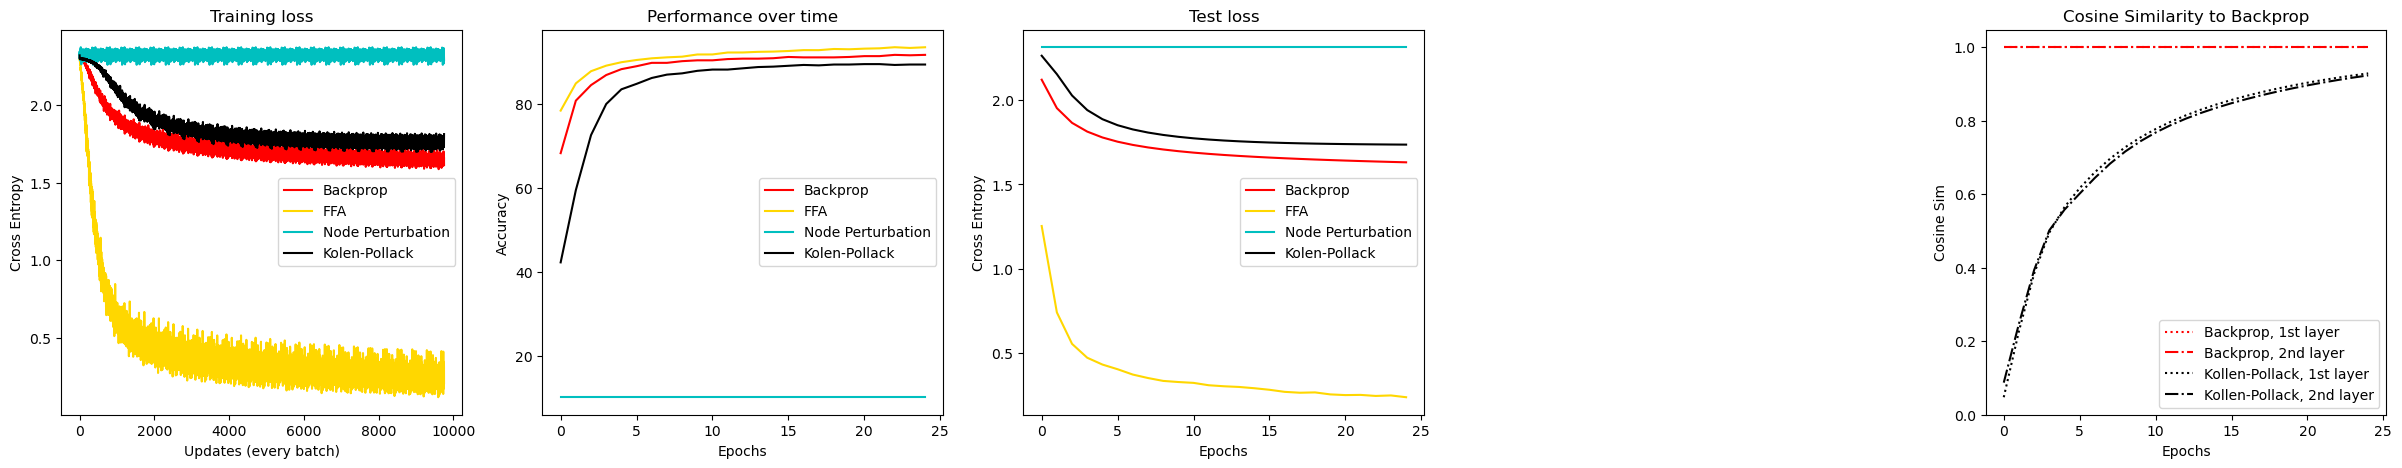

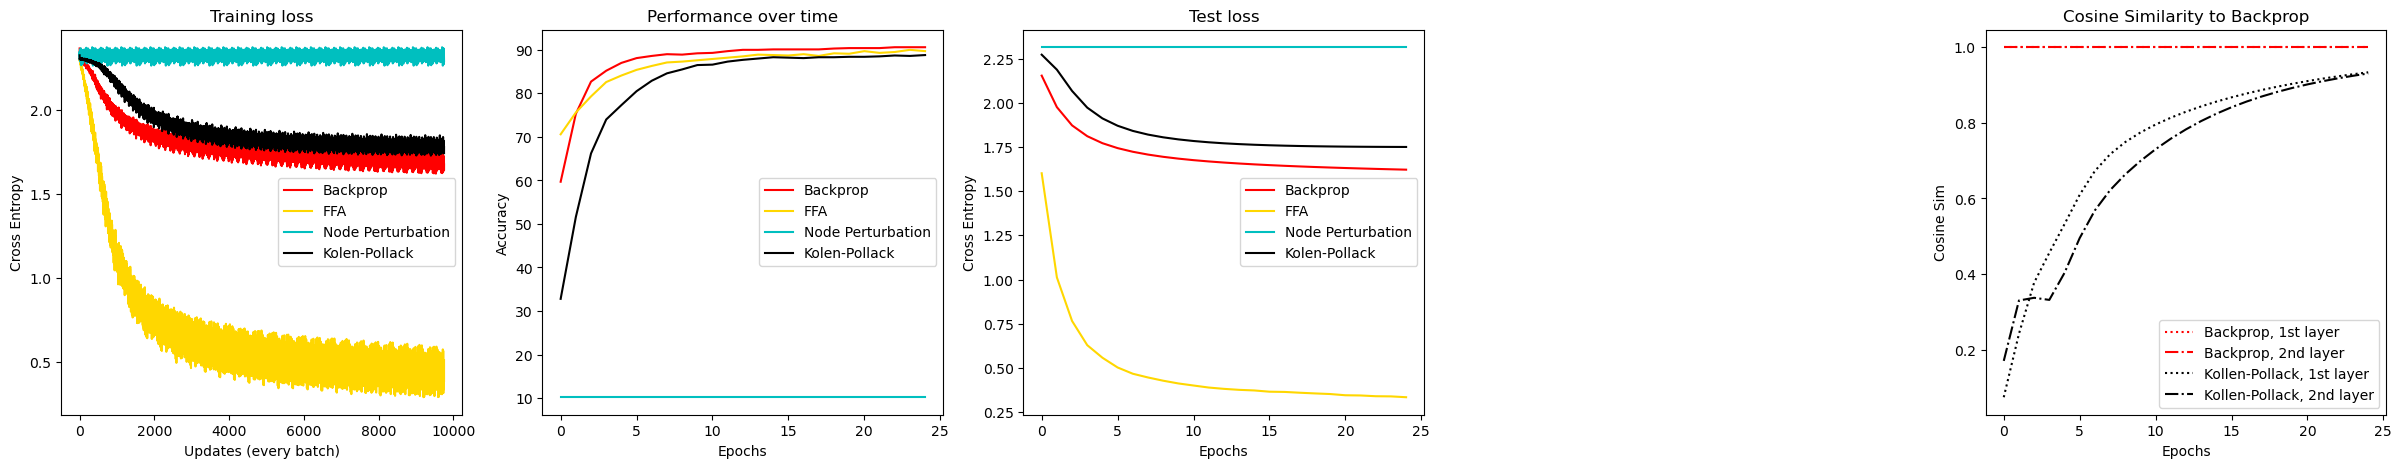

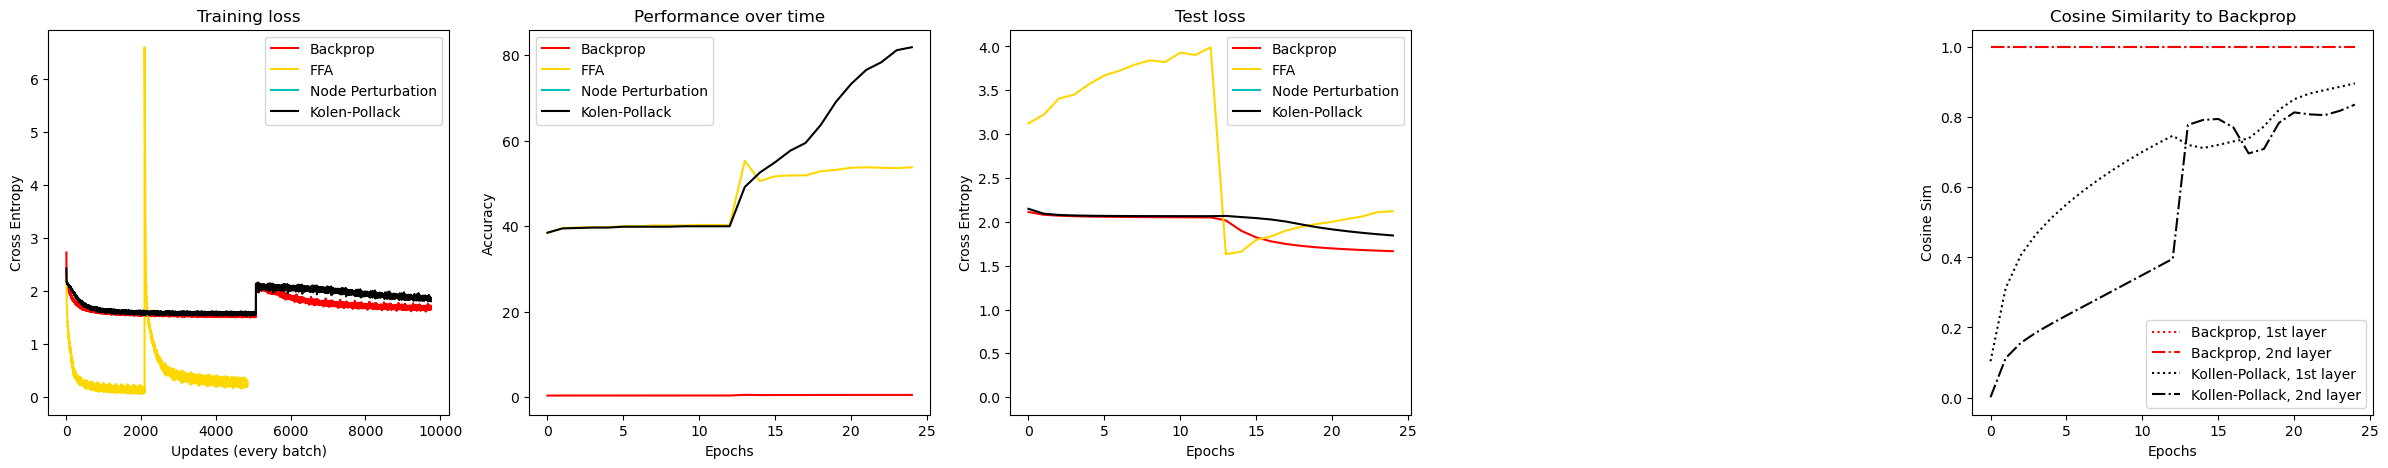

In [47]:
# plotting
for i, algo in enumerate(algos):
    if algo == 'normal':
        tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_normal, te_acc_normal, te_loss_normal, snr_normal, cosine_similarity_normal
    # elif algo == 'online':
    #     tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_online, te_acc_online, te_loss_online, snr_online, cosine_similarity_online
    elif algo == 'noisy':
        tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_noisy, te_acc_noisy, te_loss_noisy, snr_noisy, cosine_similarity_noisy
    elif algo == 'nonstat':
        tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_nonstat, te_acc_nonstat, te_loss_nonstat, snr_nonstat, cosine_similarity_nonstat
    
    print(algo)
    
    # plot
    plt.figure(figsize=(30, 5))
    plt.subplot(151)

    plt.plot(tr_loss[0], label="Backprop", color='r')
    plt.plot(tr_loss[1], label="FFA", color='gold')
    plt.plot(tr_loss[2], label="Node Perturbation", color='c')
    plt.plot(tr_loss[3], label="Kolen-Pollack", color='k')
    
    plt.xlabel("Updates (every batch)")
    plt.ylabel("Cross Entropy")
    plt.legend()
    plt.title("Training loss")

    plt.subplot(152)
    plt.plot(te_acc[0], label="Backprop", color='r')
    plt.plot(te_acc[1] * 100, label="FFA", color='gold')
    plt.plot(te_acc[2], label="Node Perturbation", color='c')
    plt.plot(te_acc[3], label="Kolen-Pollack", color='k')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Performance over time")

    plt.subplot(153)
    plt.plot(te_loss[0], label="Backprop", color='r')
    plt.plot(te_loss[1], label="FFA", color='gold')
    plt.plot(te_loss[2], label="Node Perturbation", color='c')
    plt.plot(te_loss[3], label="Kolen-Pollack", color='k')
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy")
    plt.legend()
    plt.title("Test loss")

    # plt.subplot(154)
    # # with plt.xkcd():
    # x = [0, 1, 2, 3]
    # snr1_vals = [snr[0][:, 1], snr[0][:, 2], snr[0][:, 3], snr[0][:, 0]]
    # snr2_vals = [snr[1][:, 1], snr[1][:, 2], snr[1][:, 3], snr[1][:, 0]]
    # colors = ['gold', 'c', 'k', 'r']
    # labels = ['FFA', 'Node Perturbation', 'Kolen Pollack', 'Backprop']
    # for i in range(len(snr1_vals)):
    #     plt.bar(x, snr1_vals[i], color=colors, tick_label=labels)
    #     plt.bar(x, snr2_vals[i], color=colors, tick_label=labels, alpha=0.5)
    # plt.xticks(rotation=90)
    # plt.ylabel('SNR')
    # plt.xlabel('Algorithm')
    # plt.title('Gradient SNR')

    plt.subplot(155)
    # with plt.xkcd():
    epochs = np.arange(0, numepochs, 1)
    plt.plot(epochs, cos_sim[0][:, 0], label="Backprop, 1st layer", color='r', linestyle=':')
    plt.plot(epochs, cos_sim[0][:, 1], label="Backprop, 2nd layer", color='r', linestyle='-.')
    # plt.plot(cos_sim[1][:, 0], label="FFA, 1st layer", color='gold', linestyle=':')
    # plt.plot(cos_sim[1][:, 1], label="FFA, 2nd layer", color='gold', linestyle='-.')
    # plt.plot(cos_sim[2][:, 0], label="Node Perturbation, 1st layer", color='c', linestyle=':')
    # plt.plot(cos_sim[2][:, 1], label="Node Perturbation, 2nd layer", color='c', linestyle='-.')
    plt.plot(epochs, cos_sim[3][:, 0], label="Kollen-Pollack, 1st layer", color='k', linestyle=':')
    plt.plot(epochs, cos_sim[3][:, 1], label="Kollen-Pollack, 2nd layer", color='k', linestyle='-.')
    plt.xlabel("Epochs")
    plt.ylabel("Cosine Sim")
    plt.legend()
    plt.title("Cosine Similarity to Backprop")
plt.show()

In [ ]:
# Online Learning separately becuase of different lenghts and additional smoothing operation
# plot
plt.figure(figsize=(30, 5))
plt.subplot(151)

plt.plot(tr_loss_online[0], label="Backprop", color='r')
plt.plot(tr_loss_online[1], label="FFA", color='gold')
plt.plot(tr_loss_online[2], label="Node Perturbation", color='c')
plt.plot(tr_loss_online[3], label="Kolen-Pollack", color='k')

plt.xlabel("Updates (every batch)")
plt.ylabel("Cross Entropy")
plt.legend()
plt.title("Training loss")

plt.subplot(152)
plt.plot(te_acc_online[0], label="Backprop", color='r')
plt.plot(te_acc_online[1], label="FFA", color='gold')
plt.plot(te_acc_online[2], label="Node Perturbation", color='c')
plt.plot(te_acc_online[3], label="Kolen-Pollack", color='k')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Performance over time")

plt.subplot(153)
plt.plot(te_loss_online[0], label="Backprop", color='r')
plt.plot(te_loss_online[1], label="FFA", color='gold')
plt.plot(te_loss_online[2], label="Node Perturbation", color='c')
plt.plot(te_loss_online[3], label="Kolen-Pollack", color='k')
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy")
plt.legend()
plt.title("Test loss")

plt.subplot(154)
with plt.xkcd():
        x = [0, 1, 2, 3]
        snr1_vals = [snr_online[0][:, 1], snr_online[0][:, 2], snr_online[0][:, 3], snr_online[0][:, 0]]
        snr2_vals = [snr_online[1][:, 1], snr_online[1][:, 2], snr_online[1][:, 3], snr_online[1][:, 0]]
        colors = ['gold', 'c', 'k', 'r']
        labels = ['FFA', 'Node Perturbation', 'Kolen Pollack', 'Backprop']
        for i in range(len(snr1_vals)):
            plt.bar(x, snr1_vals[i], color=colors, tick_label=labels)
            plt.bar(x, snr2_vals[i], color=colors, tick_label=labels, alpha=0.5)
        plt.xticks(rotation=90)
        plt.ylabel('SNR')
        plt.xlabel('Algorithm')
        plt.title('Gradient SNR')

plt.subplot(155)
with plt.xkcd():
    epochs = np.arange(0, numepochs, 1)
    plt.plot(epochs, cosine_similarity_online[0][:, 0], label="Backprop, 1st layer", color='r', linestyle=':')
    plt.plot(epochs, cosine_similarity_online[0][:, 1], label="Backprop, 2nd layer", color='r', linestyle='-.')
    # plt.plot(cos_sim[1][:, 0], label="FFA, 1st layer", color='gold', linestyle=':')
    # plt.plot(cos_sim[1][:, 1], label="FFA, 2nd layer", color='gold', linestyle='-.')
    # plt.plot(cos_sim[2][:, 0], label="Node Perturbation, 1st layer", color='c', linestyle=':')
    # plt.plot(cos_sim[2][:, 1], label="Node Perturbation, 2nd layer", color='c', linestyle='-.')
    plt.plot(epochs, cosine_similarity_online[3][:, 0], label="Kollen-Pollack, 1st layer", color='k', linestyle=':')
    plt.plot(epochs, cosine_similarity_online[3][:, 1], label="Kollen-Pollack, 2nd layer", color='k', linestyle='-.')
    plt.xlabel("Epochs")
    plt.ylabel("Cosine Sim")
    plt.legend()
    plt.title("Cosine Similarity to Backprop")

plt.show()